In [1]:
from os import name
from neuron import h, gui
from neuron.units import ms, mV

h.load_file("stdrun.hoc")

%matplotlib inline

Exercise 1


In [2]:
class Cell:
    def __init__(self, gid, x, y, z, theta, syn_e):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics(syn_e)
        self.x = self.y = self.z = 0
        h.define_shape()
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i,
                    sec.x3d(i),
                    sec.y3d(i),
                    0,
                    sec.diam3d(i),
                )

        self._rotate_z(theta)
        self._set_position(x, y, z)

        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)

        self._ncs = []

        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)

    def __repr__(self):
        return "{}[{}]".format(self.name, self._gid)

    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i,
                    x - self.x + sec.x3d(i),
                    y - self.y + sec.y3d(i),
                    z - self.z + sec.z3d(i),
                    sec.diam3d(i),
                )
        self.x, self.y, self.z = x, y, z

    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

In [3]:
class BallAndStick(Cell):
    name = "BallAndStick"

    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.dend = h.Section(name="dend", cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self, e=None):
        for sec in self.all:
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
        self.soma.insert("hh")
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003  # Leak conductance in S/cm2
            seg.hh.el = -54.3  # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert("pas")
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65  # Leak reversal potential mV

        # NEW: the synapse
        self.syn = h.ExpSyn(self.dend(0.5))
        self.syn.tau = 2 * ms
        # if e is not None:
        #     print("syn.e = {}".format(e))
        #     self.syn.e = e
        # else:
        #     self.syn.e = 0

In [4]:
class Ring:
    sections = []
    """A network of *N* ball-and-stick cells where cell n makes an
    excitatory synapse onto cell n + 1 and the last, Nth cell in the
    network projects to the first cell.
    """

    def __init__(
        self,
        N=5,
        stim_w=0.04,
        stim_t=9,
        stim_delay=1,
        syn_w=0.01,
        syn_delay=5,
        r=50,
        z=0,
        inhibitory=False,
    ):
        """
        :param N: Number of cells.
        :param stim_w: Weight of the stimulus
        :param stim_t: time of the stimulus (in ms)
        :param stim_delay: delay of the stimulus (in ms)
        :param syn_w: Synaptic weight
        :param syn_delay: Delay of the synapse
        :param r: radius of the network
        """
        self._syn_w = syn_w
        self._syn_delay = syn_delay

        if inhibitory:
            self._create_cells(N, r, z, -70 * mV)
        else:
            self._create_cells(N, r, z, 0)

        if not inhibitory:
            self._connect_cells()
            # add stimulus
            self._netstim = h.NetStim()
            self._netstim.number = 1
            self._netstim.start = stim_t
            self._nc = h.NetCon(self._netstim, self.cells[0].syn)
            self._nc.delay = stim_delay
            self._nc.weight[0] = stim_w

    def _create_cells(self, N, r, z, e):
        self.cells = []
        for i in range(N):
            theta = i * 2 * h.PI / N
            self.cells.append(
                BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, z, theta, e)
            )

    def _connect_cells(self):
        for source, target in zip(self.cells, self.cells[1:] + [self.cells[0]]):
            nc = h.NetCon(source.soma(0.5)._ref_v, target.syn, sec=source.soma)
            nc.weight[0] = self._syn_w
            nc.delay = self._syn_delay
            # draw connection as dendrite
            sec = h.Section(name=f"{source}_to_{target}")
            sec.diam = 2
            sec.pt3dadd(
                source.x,
                source.y,
                source.z,
                2,
            )
            sec.pt3dadd(
                target.x,
                target.y,
                target.z,
                2,
            )

            self.sections.append(sec)
            source._ncs.append(nc)


ring_to_ring_sections = []

circles = []


def draw_circle_around(sec, x, y, z, r):
    """Draw a circle around a section."""
    for theta in range(0, 360, 7):
        sec.pt3dadd(
            x + r * h.cos(theta),
            y + r * h.sin(theta),
            z,
            2,
        )
    circles.append(sec)


def connect_rings(r1: Ring, r2: Ring, inhibitory=False):
    """Connect two rings."""
    for r1_cell, r2_cell in zip(r1.cells, r2.cells):
        if inhibitory:
            r2_cell.syn.e = -70 * mV
        nc = h.NetCon(r1_cell.soma(0.5)._ref_v, r2_cell.syn, sec=r1_cell.soma)
        nc.weight[0] = r1._syn_w
        print(r1._syn_w)
        nc.delay = r1._syn_delay
        print(nc.delay)
        r1_cell._ncs.append(nc)

        sec = h.Section(name=f"{r1_cell}_to_{r2_cell}")
        sec.diam = 2
        sec.pt3dadd(
            r1_cell.x,
            r1_cell.y,
            r1_cell.z,
            2,
        )
        sec.pt3dadd(
            r2_cell.x,
            r2_cell.y,
            r2_cell.z,
            2,
        )
        if r2_cell.syn.e < 0:
            draw_circle_around(sec, r2_cell.x, r2_cell.y, r2_cell.z, 5)
        else:
            draw_circle_around(sec, r2_cell.x, r2_cell.y, r2_cell.z, 25)

        ring_to_ring_sections.append(sec)

In [5]:
import neuron
import importlib

importlib.reload(neuron)
h = neuron.h

print("excitatory")
ring = Ring(N=5, r=50, z=0, inhibitory=False)
print("inhibitory")
ring2 = Ring(N=5, r=25, z=10, stim_w=0, inhibitory=True)

connect_rings(ring, ring2)
connect_rings(ring2, ring, inhibitory=True)

excitatory
inhibitory
0.01
5.0
0.01
5.0
0.01
5.0
0.01
5.0
0.01
5.0
0.01
5.0
0.01
5.0
0.01
5.0
0.01
5.0
0.01
5.0


In [6]:
import plotly

ps = h.PlotShape(True)
ps.variable("v")
ps.scale(-80, 40)
ps.exec_menu("Shape Plot")
ps.exec_menu("Show Diam")

# visualize all netcons on the 3d plot
# for nc in ring.cells[0]._ncs:
#     plotly_trace = ps.plot(plotly)
#     plotly_trace.line.width = 10
#     plotly_trace.line.color = "red"
#     plotly_trace.line.dash = "dash"
#     plotly_trace.line.smoothing = 1.3

ps.plot(plotly).show()

In [7]:
shape_window = h.PlotShape(True)
shape_window.show(0)

1.0

In [8]:
t = h.Vector().record(h._ref_t)
h.finitialize(-65 * mV)
h.continuerun(100)

0.0

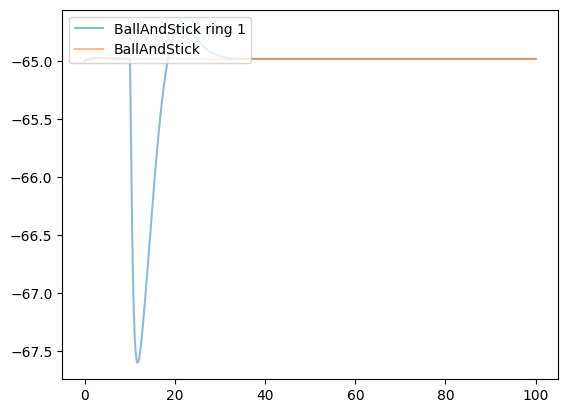

In [9]:
import matplotlib.pyplot as plt

plt.plot(t, list(ring.cells[0].soma_v), alpha=0.5)
plt.plot(t, list(ring2.cells[0].soma_v), alpha=0.5)
plt.legend(
    [f"{ring.cells[0].name} ring 1", ring2.cells[0].name],
    loc="upper left",
)
plt.show()

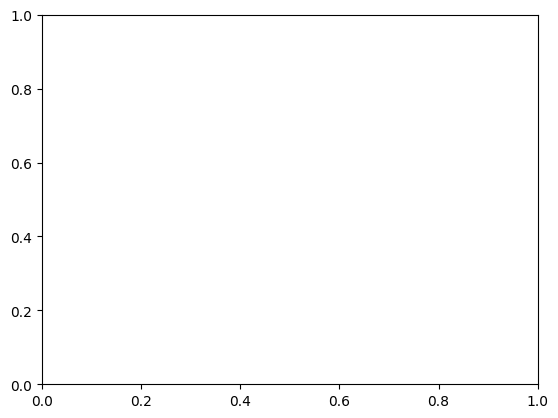

In [10]:
plt.figure()
for i, cell in enumerate(ring.cells):
    plt.vlines(list(cell.spike_times), i + 0.5, i + 1.5)
plt.show()

In [11]:
from neuron import h, rxd

# Define regions: cytosol for astrocyte and ECS (extracellular space)
astrocyte = h.Section(name="astrocyte")
cytosol_a = rxd.Region([astrocyte], name="cytosol_a", nrn_region="i")
ecs = rxd.Extracellular(-100, -100, -100, 100, 100, 100, dx=33)

# Add species: intracellular calcium, glutamate in cytosol and ECS
ca = rxd.Species(cytosol_a, name="ca", charge=2, initial=0.1)
glutamate_cytosol = rxd.Species(
    cytosol_a, name="glutamate_cytosol", charge=0, initial=0
)
glutamate_ecs = rxd.Species(ecs, name="glutamate_ecs", charge=0, initial=0)

# Define reaction mechanisms
ip3r = rxd.Rate(ca, -0.1 * ca + 0.01 * glutamate_ecs)
glutamate_release = rxd.Rate(
    glutamate_cytosol, -0.1 * glutamate_cytosol
)  # Simplified release
glutamate_diffusion = rxd.MultiCompartmentReaction(
    glutamate_cytosol, glutamate_ecs, rate=1, membrane_flux=True
)


# Astrocytic glutamate release function
def astrocyte_glutamate_release():
    """Function to model astrocytic glutamate release."""
    # Increase the glutamate concentration in astrocyte cytosol
    glutamate_cytosol[cytosol_a].concentration += 1


# Define a neuron affected by glutamate
neuron = h.Section(name="neuron")
synapse = h.ExpSyn(neuron(0.5))  # excitatory synapse
synapse.e = 0  # reversal potential for glutamate receptor (example value)

# Connect glutamate in ECS to neuronal synapse
glutamate_ecs.on_grid().nodes.concentration_changes.append(
    lambda nodes: synapse_input(nodes, synapse)
)


def synapse_input(nodes, synapse):
    """Updates synaptic conductance based on glutamate concentration."""
    synapse.g = sum(node.concentration for node in nodes)  # Example: linear relation


# Record glutamate in ECS and synaptic conductance
glut_ecs_vec = h.Vector().record(glutamate_ecs.nodes[0]._ref_concentration)
syn_g_vec = h.Vector().record(synapse._ref_g)

# Simulation control
h.tstop = 100
astrocyte_glutamate_release()  # stimulate astrocytic glutamate release at some point
h.run()

# Plot results (assuming Matplotlib is installed)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(h.Vector().record(h._ref_t), glut_ecs_vec, label="ECS Glutamate")
plt.xlabel("Time (ms)")
plt.ylabel("Glutamate Concentration (mM)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h.Vector().record(h._ref_t), syn_g_vec, label="Synaptic Conductance")
plt.xlabel("Time (ms)")
plt.ylabel("Conductance (S)")
plt.legend()

plt.tight_layout()
plt.show()

Exception ignored on calling ctypes callback function: <function _setup at 0x16ac59b20>
Traceback (most recent call last):
  File "/Users/mehow/src-uni/neuron/.venv/lib/python3.11/site-packages/neuron/rxd/rxd.py", line 485, in _setup
    initializer._do_init()
  File "/Users/mehow/src-uni/neuron/.venv/lib/python3.11/site-packages/neuron/rxd/initializer.py", line 58, in _do_init
    rxd._init()
  File "/Users/mehow/src-uni/neuron/.venv/lib/python3.11/site-packages/neuron/rxd/rxd.py", line 1878, in _init
    _compile_reactions()
  File "/Users/mehow/src-uni/neuron/.venv/lib/python3.11/site-packages/neuron/rxd/rxd.py", line 1371, in _compile_reactions
    rate_str = localize_index(creg, r._rate[reg()][0])
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mehow/src-uni/neuron/.venv/lib/python3.11/site-packages/neuron/rxd/rxd.py", line 1322, in localize_index
    rate_str = re.sub(
               ^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python

RxDException: Species(regions=[Region(..., nrn_region='i', geometry=<neuron.rxd.geometry.RxDGeometry object at 0x16a996890>, dx=None, name='cytosol_a')], d=0, name='glutamate_cytosol', charge=0, initial=0) not a recognized reaction scheme

In [ ]:
import neuron
from neuron import h
from neuron import rxd

# Initialize regions
cytosol = rxd.Region(h.allsec(), nrn_region="i", name="cytosol")

# Define species
glutamate = rxd.Species(cytosol, d=0, name="glutamate_cytosol", charge=0, initial=0)

# Set up reaction scheme (if you have one)
# Example reaction: glutamate -> GABA with rate constant k
GABA = rxd.Species(cytosol, d=0, name="GABA_cytosol", charge=0, initial=0)
reaction_scheme = rxd.Reaction(glutamate, GABA, rate=1)

# Initialize RxD
neuron.init()

RxDException: Species(regions=[Region(..., nrn_region='i', geometry=<neuron.rxd.geometry.RxDGeometry object at 0x122b2a8d0>, dx=None, name='cytosol')], d=0, name='glutamate_cytosol', charge=0, initial=0) not a recognized reaction scheme

In [ ]:
neuron.__version__

'8.2.3+'

In [ ]:
W